In [120]:
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Input, Embedding, Flatten, Concatenate, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

In [121]:
df = joblib.load('df.pkl')

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Company       1303 non-null   object 
 1   TypeName      1303 non-null   object 
 2   Inches        1303 non-null   float64
 3   Ram           1303 non-null   int64  
 4   OpSys         1303 non-null   object 
 5   Weight        1303 non-null   float64
 6   Price         1303 non-null   int64  
 7   Touchscreen   1303 non-null   int64  
 8   Panel         1303 non-null   object 
 9   PPI           1303 non-null   float64
 10  Processor     1303 non-null   object 
 11  Gpu_Brand     1303 non-null   object 
 12  HDD           1303 non-null   int64  
 13  SSD           1303 non-null   int64  
 14  Memory_Types  1303 non-null   object 
dtypes: float64(3), int64(5), object(7)
memory usage: 152.8+ KB


In [123]:
df['Price'] = np.log1p(df['Price'])

In [124]:
cat_cols = ['Company', 'TypeName', 'OpSys', 'Panel', 'Processor', 'Gpu_Brand', 'Memory_Types']
num_cols = ['Inches', 'Ram', 'Weight', 'PPI', 'Touchscreen', 'HDD','SSD']

In [125]:
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [126]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [127]:
X_cat = [df[col].values for col in cat_cols]
X_num = df[num_cols].values
y = df['Price'].values

In [128]:
X_cat_stacked = np.stack(X_cat, axis=1) 
X_cat_train, X_cat_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
    X_cat_stacked, X_num, y, test_size=0.2, random_state=42
)

X_cat_train = [X_cat_train[:, i] for i in range(X_cat_stacked.shape[1])]
X_cat_val   = [X_cat_val[:, i] for i in range(X_cat_stacked.shape[1])]

In [129]:
def build_model(hp, cat_vocab_sizes, num_features):
    inputs = []
    embeddings = []

    # Categorical inputs with Embedding
    for i, vocab_size in enumerate(cat_vocab_sizes):
        input_i = Input(shape=(1,), name=f"cat_input_{i}")
        embed_dim = hp.Int(f"embed_dim_{i}", min_value=2, max_value=8, step=2)
        embed_i = Embedding(input_dim=vocab_size + 1, output_dim=embed_dim)(input_i)
        embed_i = Flatten()(embed_i)
        inputs.append(input_i)
        embeddings.append(embed_i)

    # Numeric input
    num_input = Input(shape=(num_features,), name="num_input")
    inputs.append(num_input)
    embeddings.append(num_input)

    # Concatenate all
    x = Concatenate()(embeddings)

    # First dense block
    x = Dense(units=hp.Int('units_input', 128, 256, step=32))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=hp.Float('dropout_input', 0.1, 0.5, step=0.1))(x)

    # Hidden layers
    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        x = Dense(units=hp.Int(f'units_{i}', 64, 256, step=32))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(rate=hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1))(x)

    # Output layer
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='mse',
        metrics=['mae']
    )
    return model

In [130]:
cat_vocab_sizes = [df[col].nunique() for col in cat_cols]
num_features = len(num_cols)

In [131]:
from keras_tuner import Hyperband

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner = Hyperband(
    hypermodel=lambda hp: build_model(hp, cat_vocab_sizes, num_features),
    objective='val_loss',
    max_epochs=100,
    directory='tuner_dir',
    project_name='laptop_ann_tuned'
)

tuner.search(
    X_cat_train + [X_num_train],
    y_train,
    validation_data=(X_cat_val + [X_num_val], y_val),
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Reloading Tuner from tuner_dir\laptop_ann_tuned\tuner0.json


In [132]:
tuner.search(
    X_cat_train + [X_num_train],
    y_train,
    validation_data=(X_cat_val + [X_num_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

In [133]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hp)

model.summary()

model.fit(
    X_cat_train + [X_num_train],
    y_train,
    validation_data=(X_cat_val + [X_num_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_input_0         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_1         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_2         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_3         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_4         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_5         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_input_6         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_30        │ (None, 1, 8)      │        160 │ cat_input_0[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_31        │ (None, 1, 4)      │         28 │ cat_input_1[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_32        │ (None, 1, 6)      │         36 │ cat_input_2[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_33        │ (None, 1, 2)      │          6 │ cat_input_3[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_34        │ (None, 1, 6)      │         36 │ cat_input_4[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_35        │ (None, 1, 6)      │         30 │ cat_input_5[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_36        │ (None, 1, 4)      │         32 │ cat_input_6[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_30          │ (None, 8)         │          0 │ embedding_30[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_31          │ (None, 4)         │          0 │ embedding_31[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_32          │ (None, 6)         │          0 │ embedding_32[0][

 Total params: 15,049 (58.79 KB)

 Trainable params: 14,665 (57.29 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 86.7860 - mae: 8.9968 - val_loss: 26.1758 - val_mae: 4.9508
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8942 - mae: 1.3675 - val_loss: 16.3403 - val_mae: 3.9145
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3618 - mae: 0.9289 - val_loss: 9.4583 - val_mae: 3.0015
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3935 - mae: 0.9442 - val_loss: 7.8644 - val_mae: 2.7558
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1927 - mae: 0.8643 - val_loss: 5.1807 - val_mae: 2.2015
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2730 - mae: 0.8923 - val_loss: 2.3994 - val_mae: 1.4257
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2379 - mae: 0.8960 - val_loss: 1.6477 - val_mae: 1.1569
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0395 - mae: 0.8073 - val_loss: 1.1498 - val_mae: 0.9722
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0597 - m

In [134]:
y_pred = model.predict(X_cat_val + [X_num_val])
y_pred_actual = np.expm1(y_pred)
y_val_actual = np.expm1(y_val)

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_val_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_actual))
r2 = r2_score(y_val_actual, y_pred_actual)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 12714.47
RMSE: 19471.93
R² Score: 0.74


In [144]:
comparison_df = pd.DataFrame({
    "Actual Price": y_val_actual[:5].flatten(),
    "Predicted Price": y_pred_actual[:5].flatten()
})

print(comparison_df)


   Actual Price  Predicted Price
0       89084.0     57362.628906
1       61218.0     62694.878906
2       26586.0     26852.427734
3       47898.0     48353.566406
4       66280.0     78746.523438


In [136]:
import matplotlib.pyplot as plt

tuner.results_summary()

tuner.search_space_summary()

Results summary
Results in tuner_dir\laptop_ann_tuned
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0146 summary
Hyperparameters:
embed_dim_0: 8
embed_dim_1: 4
embed_dim_2: 6
embed_dim_3: 2
embed_dim_4: 6
embed_dim_5: 6
embed_dim_6: 4
units_input: 128
dropout_input: 0.2
num_hidden_layers: 1
units_0: 64
dropout_0: 0.1
lr: 0.008552788406092913
units_1: 256
dropout_1: 0.5
units_2: 160
dropout_2: 0.5
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.04494423419237137

Trial 0147 summary
Hyperparameters:
embed_dim_0: 2
embed_dim_1: 6
embed_dim_2: 6
embed_dim_3: 4
embed_dim_4: 8
embed_dim_5: 8
embed_dim_6: 8
units_input: 192
dropout_input: 0.5
num_hidden_layers: 1
units_0: 96
dropout_0: 0.1
lr: 0.007906048426015538
units_1: 64
dropout_1: 0.1
units_2: 256
dropout_2: 0.30000000000000004
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142
Score: 0.04947277903556824

Trial

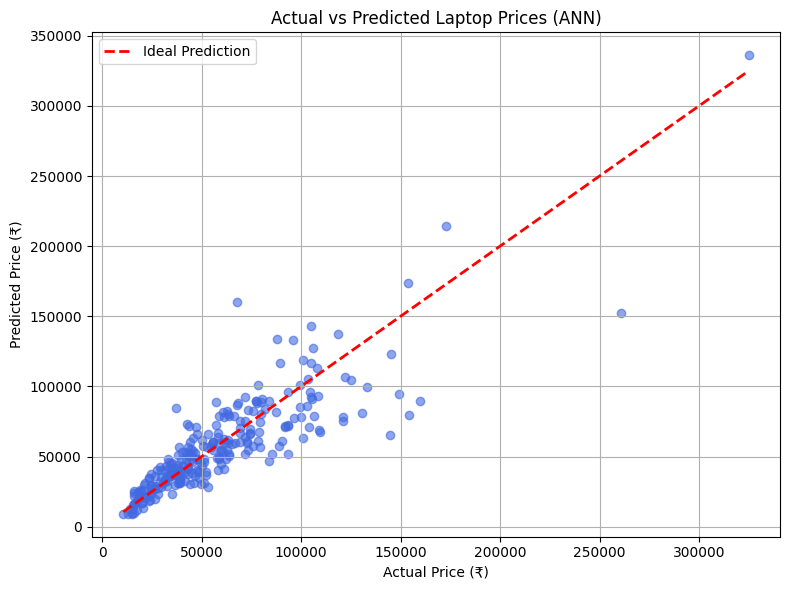

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_val_actual, y_pred_actual, alpha=0.6, color='royalblue')
plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()],
         'r--', lw=2, label="Ideal Prediction")

plt.title("Actual vs Predicted Laptop Prices (ANN)")
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [143]:
import joblib
import pickle
import json

# 1. Save the trained ANN model
model.save("ann_model.h5")

# 2. Save label encoders used for embeddings
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

# 3. Save numeric scaler (e.g., StandardScaler or MinMaxScaler)
joblib.dump(scaler, "num_scaler.pkl")

# 4. Save list of categorical and numerical columns (optional but useful)
with open("ann_columns.json", "w") as f:
    json.dump({
        "cat_cols": cat_cols,
        "num_cols": num_cols
    }, f)
